In [45]:
!pip install -q pyomo

In [50]:
!apt-get install -y -qq glpk-utils

# A Transportation Problem

This problem finds a least cost shipping schedule that meets
requirements at markets and supplies at factories.


Dantzig, G B, Chapter 3.3. In Linear Programming and Extensions.
Princeton University Press, Princeton, New Jersey, 1963.

This formulation is described in detail in:
Rosenthal, R E, Chapter 2: A GAMS Tutorial. In GAMS: A User's Guide.
The Scientific Press, Redwood City, California, 1988.

The line numbers will not match those in the book because of these
comments.

Keywords: linear programming, transportation problem, scheduling

In [46]:
from geopy.geocoders import Nominatim

# Lista de ciudades en A y B
A = ['seattle', 'san-diego'] # nodos origen
B = ['new-york', 'chicago', 'topeka'] # nodos destinos

# Crear un objeto de geolocalizador de Nominatim
geolocator = Nominatim(user_agent="myGeocoder")

# Obtener coordenadas de ciudades en la lista A
coordenadas_A = {}
for ciudad in A:
    location = geolocator.geocode(ciudad)
    if location is not None:
        coordenadas_A[ciudad] = (location.latitude, location.longitude)
    else:
        coordenadas_A[ciudad] = (None, None)

# Obtener coordenadas de ciudades en la lista B
coordenadas_B = {}
for ciudad in B:
    location = geolocator.geocode(ciudad)
    if location is not None:
        coordenadas_B[ciudad] = (location.latitude, location.longitude)
    else:
        coordenadas_B[ciudad] = (None, None)

# Imprimir resultados
print("Coordenadas de ciudades en A:")
for ciudad, Ubi in coordenadas_A.items():
    print(f"Ciudad: {ciudad}, Latitud: {Ubi[0]}, Longitud: {Ubi[1]}")

print("Coordenadas de ciudades en B:")
for ciudad, Ubi in coordenadas_B.items():
    print(f"Ciudad: {ciudad}, Latitud: {Ubi[0]}, Longitud: {Ubi[1]}")




Coordenadas de ciudades en A:
Ciudad: seattle, Latitud: 47.6038321, Longitud: -122.330062
Ciudad: san-diego, Latitud: 32.7174202, Longitud: -117.1627728
Coordenadas de ciudades en B:
Ciudad: new-york, Latitud: 40.7127281, Longitud: -74.0060152
Ciudad: chicago, Latitud: 41.8755616, Longitud: -87.6244212
Ciudad: topeka, Latitud: 39.049011, Longitud: -95.677556


In [47]:
ciudades = {**coordenadas_A,**coordenadas_B}

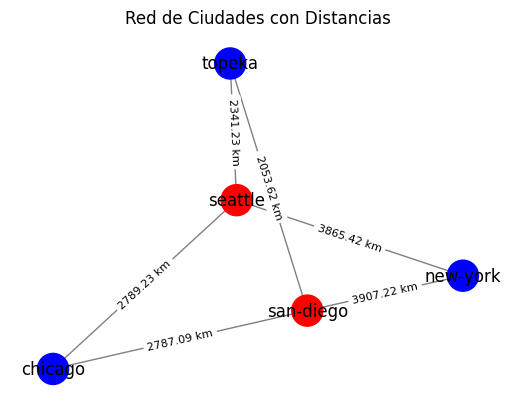

In [62]:
import networkx as nx
import matplotlib.pyplot as plt
from geopy.distance import great_circle

# Crear un grafo vacío
G = nx.Graph()

# Agregar nodos con nombres de ciudades como etiquetas
# Agregar nodos de ciudades en A con color rojo
for ciudad in coordenadas_A.keys():
    G.add_node(ciudad, color='red')

# Agregar nodos de ciudades en B con color azul
for ciudad in coordenadas_B.keys():
    G.add_node(ciudad, color='blue')

# Calcular y agregar aristas (conexiones) con la distancia entre ciudades
for ciudad1, coord1 in coordenadas_A.items():
    for ciudad2, coord2 in coordenadas_B.items():
      distancia = great_circle(coord1, coord2).km  # Calcular distancia en kilómetros
      G.add_edge(ciudad1, ciudad2, weight=distancia)  # Agregar arista con atributo de peso (distancia)

# Visualizar el grafo con etiquetas de ciudades y pesos en las aristas
pos = nx.spring_layout(G)  # Asignar posiciones a los nodos
# Obtener colores de nodos
colors = [G.nodes[node]['color'] for node in G.nodes()]

nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=500)  # Dibujar nodos
nx.draw_networkx_labels(G, pos, labels={ciudad: ciudad for ciudad in ciudades})  # Dibujar etiquetas de ciudades
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)  # Dibujar aristas
nx.draw_networkx_edge_labels(G, pos, edge_labels={(ciudad1, ciudad2): f"{distancia:.2f} km" for (ciudad1, ciudad2, distancia) in G.edges(data='weight')}, label_pos=0.5, font_size=8)  # Dibujar etiquetas de pesos en aristas
plt.axis('off')  # Desactivar los ejes
plt.title("Red de Ciudades con Distancias")  # Agregar título al grafo
plt.show()  # Mostrar el grafo

In [53]:
from pyomo.environ import *

A = list(coordenadas_A.keys())
B = list(coordenadas_B.keys())

# Definición de parámetros
a = {'seattle': 350, 'san-diego': 600}
b = {'new-york': 325, 'chicago': 300, 'topeka': 275}

f = 90 # fletes en dolares por caja

# Cálculo de costos de transporte
c = {(i, j): f * G.get_edge_data(i, j)['weight'] / 1000 for i in coordenadas_A for j in coordenadas_B}

# Creación del modelo
transport = ConcreteModel("Transport")

# Definición de variables
transport.x = Var(A, B, within=NonNegativeReals)

# Definición de función objetivo
transport.cost = Objective(expr=sum(c[i, j] * transport.x[i, j] for i in A for j in B), sense=minimize)

# Definición de restricciones
transport.supply = ConstraintList()
for i in A:
    transport.supply.add(sum(transport.x[i, j] for j in B) <= a[i])

transport.demand = ConstraintList()
for j in B:
    transport.demand.add(sum(transport.x[i, j] for i in A) >= b[j])

transport.pprint()


5 Set Declarations
    demand_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {1, 2, 3}
    supply_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    2 : {1, 2}
    x_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain              : Size : Members
        None :     2 : x_index_0*x_index_1 :    6 : {('seattle', 'new-york'), ('seattle', 'chicago'), ('seattle', 'topeka'), ('san-diego', 'new-york'), ('san-diego', 'chicago'), ('san-diego', 'topeka')}
    x_index_0 : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    2 : {'seattle', 'san-diego'}
    x_index_1 : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {'new-york', 'chicago', 'topeka'}

1 Var Declarations
    x : S

In [55]:
# Resolución del modelo
SolverFactory('glpk', executable='/usr/bin/glpsol').solve(transport).write()

sol_transport = {}

# Impresión de resultados
for i in A:
    for j in B:
      print(f"x[{i},{j}] = {transport.x[i, j].value:.2f}")
      if transport.x[i, j].value > 0:
        sol_transport[(i,j)] = transport.x[i, j].value
      
print(f"z = {transport.cost():.2f}")

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 239141.973211928
  Upper bound: 239141.973211928
  Number of objectives: 1
  Number of constraints: 6
  Number of variables: 7
  Number of nonzeros: 13
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.015187978744506836
# ----------------------------------------------------------
#   Solution Information
# -------------

In [56]:
sol_transport

{('seattle', 'new-york'): 325.0,
 ('san-diego', 'chicago'): 300.0,
 ('san-diego', 'topeka'): 275.0}

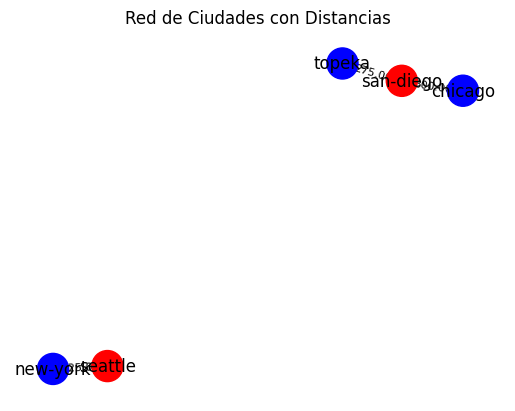

In [67]:
# Crear un grafo vacío
G = nx.Graph()

# Agregar nodos con nombres de ciudades como etiquetas
for ciudad in coordenadas_A.keys():
    G.add_node(ciudad, color='red')

# Agregar nodos de ciudades en B con color azul
for ciudad in coordenadas_B.keys():
    G.add_node(ciudad, color='blue')

# Calcular y agregar aristas (conexiones) con la distancia entre ciudades
for ciudad1, coord1 in coordenadas_A.items():
    for ciudad2, coord2 in coordenadas_B.items():
      distancia = sol_transport.get((ciudad1,ciudad2),0)
      if distancia >0 :
        G.add_edge(ciudad1, ciudad2, weight=distancia)  # Agregar arista con atributo de peso (distancia)

# Visualizar el grafo con etiquetas de ciudades y pesos en las aristas
pos = nx.spring_layout(G)  # Asignar posiciones a los nodos
colors = [G.nodes[node]['color'] for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=500)  # Dibujar nodos
nx.draw_networkx_labels(G, pos, labels={ciudad: ciudad for ciudad in ciudades})  # Dibujar etiquetas de ciudades
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)  # Dibujar aristas
nx.draw_networkx_edge_labels(G, pos, edge_labels={(ciudad1, ciudad2): f"{distancia:.2f}" for (ciudad1, ciudad2, distancia) in G.edges(data='weight')}, label_pos=0.5, font_size=8)  # Dibujar etiquetas de pesos en aristas
plt.axis('off')  # Desactivar los ejes
plt.title("Red de Ciudades con Distancias")  # Agregar título al grafo
plt.show()  # Mostrar el grafo